## Copyright 2022 Google LLC. Double-click for license information.

#Copyright

In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Clone Original Repo

In [2]:
!git clone https://github.com/google/prompt-to-prompt.git
import sys
sys.path.insert(0, '/content/prompt-to-prompt')

Cloning into 'prompt-to-prompt'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 52 (delta 11), reused 10 (delta 10), pack-reused 36
Unpacking objects: 100% (52/52), 33.06 MiB | 8.65 MiB/s, done.


#Install Requirements for Colab T4

In [3]:
!nvidia-smi -L

!pip install -U --pre triton
!pip install torchinfo
!pip install xformers==0.0.16rc425

!pip install diffusers==0.7.2
!pip install transformers==4.22.2
!pip install accelerate==0.12.0
!pip install ftfy

GPU 0: Tesla T4 (UUID: GPU-c1c4b974-15cc-5e76-5a4b-a46c44e0841e)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 876.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requ

#Not needed

In [4]:
#Other things used in testing

#!pip install ninja
#!pip install triton==2.0.0.dev20221202

#installing triton from source is slow, but I couldn't get the prebuilt binary wheels to work on colab.
#!git clone https://github.com/openai/triton.git
#!pip install -e /content/triton/python

#!pip install --pre torch

#this still takes a couple of minutes but it's better than building it from source!
#!pip install xformers==0.0.12 #pytorch_lightning numpy

#!pip install -U --pre torchvision
#!pip install -U --pre torchtext
#!pip install -U --pre torchaudio


In [5]:
!git clone https://github.com/google/prompt-to-prompt.git

fatal: destination path 'prompt-to-prompt' already exists and is not an empty directory.


In [6]:
import sys
sys.path.insert(0, '/content/prompt-to-prompt')

# Null-text inversion + Editing with Prompt-to-Prompt


In [7]:
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm.notebook import tqdm
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import torch.nn.functional as nnf
import numpy as np
import abc
#import ptp_utils  #instead, mod for half precision below
import seq_aligner
import shutil
from torch.optim.adam import Adam
from PIL import Image

#ptp_utils pulled in from repo and modified

In [8]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
import cv2
from typing import Optional, Union, Tuple, List, Callable, Dict
from IPython.display import display
from tqdm.notebook import tqdm

class ptp_utils:

  def text_under_image(image: np.ndarray, text: str, text_color: Tuple[int, int, int] = (0, 0, 0)):
      h, w, c = image.shape
      offset = int(h * .2)
      img = np.ones((h + offset, w, c), dtype=np.uint8) * 255
      font = cv2.FONT_HERSHEY_SIMPLEX
      # font = ImageFont.truetype("/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf", font_size)
      img[:h] = image
      textsize = cv2.getTextSize(text, font, 1, 2)[0]
      text_x, text_y = (w - textsize[0]) // 2, h + offset - textsize[1] // 2
      cv2.putText(img, text, (text_x, text_y ), font, 1, text_color, 2)
      return img


  def view_images(images, num_rows=1, offset_ratio=0.02):
      if type(images) is list:
          num_empty = len(images) % num_rows
      elif images.ndim == 4:
          num_empty = images.shape[0] % num_rows
      else:
          images = [images]
          num_empty = 0

      empty_images = np.ones(images[0].shape, dtype=np.uint8) * 255
      images = [image.astype(np.uint8) for image in images] + [empty_images] * num_empty
      num_items = len(images)

      h, w, c = images[0].shape
      offset = int(h * offset_ratio)
      num_cols = num_items // num_rows
      image_ = np.ones((h * num_rows + offset * (num_rows - 1),
                        w * num_cols + offset * (num_cols - 1), 3), dtype=np.uint8) * 255
      for i in range(num_rows):
          for j in range(num_cols):
              image_[i * (h + offset): i * (h + offset) + h:, j * (w + offset): j * (w + offset) + w] = images[
                  i * num_cols + j]

      pil_img = Image.fromarray(image_)
      display(pil_img)


  def diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False):
      if low_resource:
          noise_pred_uncond = model.unet(latents.half(), t, encoder_hidden_states=context[0])["sample"]
          noise_prediction_text = model.unet(latents.half(), t, encoder_hidden_states=context[1])["sample"]
      else:
          latents_input = torch.cat([latents.half()] * 2)
          noise_pred = model.unet(latents_input.half(), t, encoder_hidden_states=context)["sample"]
          noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
      latents = model.scheduler.step(noise_pred, t, latents)["prev_sample"]
      latents = controller.step_callback(latents)
      return latents


  def latent2image(vae, latents):
      latents = 1 / 0.18215 * latents
      image = vae.decode(latents.half())['sample']
      image = (image / 2 + 0.5).clamp(0, 1)
      image = image.cpu().permute(0, 2, 3, 1).numpy()
      image = (image * 255).astype(np.uint8)
      return image


  def init_latent(latent, model, height, width, generator, batch_size):
      if latent is None:
          latent = torch.randn(
              (1, model.unet.in_channels, height // 8, width // 8),
              generator=generator,
          )
      latents = latent.expand(batch_size,  model.unet.in_channels, height // 8, width // 8).to(model.device)
      return latent, latents


  @torch.no_grad()
  def text2image_ldm(
      model,
      prompt:  List[str],
      controller,
      num_inference_steps: int = 50,
      guidance_scale: Optional[float] = 7.,
      generator: Optional[torch.Generator] = None,
      latent: Optional[torch.HalfTensor] = None,
  ):
      register_attention_control(model, controller)
      height = width = 256
      batch_size = len(prompt)

      uncond_input = model.tokenizer([""] * batch_size, padding="max_length", max_length=77, return_tensors="pt")
      uncond_embeddings = model.bert(uncond_input.input_ids.to(model.device))[0]

      text_input = model.tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt")
      text_embeddings = model.bert(text_input.input_ids.to(model.device))[0]
      latent, latents = init_latent(latent, model, height, width, generator, batch_size)
      context = torch.cat([uncond_embeddings, text_embeddings])

      model.scheduler.set_timesteps(num_inference_steps)
      for t in tqdm(model.scheduler.timesteps):
          latents = diffusion_step(model, controller, latents, context, t, guidance_scale)

      image = latent2image(model.vqvae, latents)

      return image, latent


  @torch.no_grad()
  def text2image_ldm_stable(
      model,
      prompt: List[str],
      controller,
      num_inference_steps: int = 50,
      guidance_scale: float = 7.5,
      generator: Optional[torch.Generator] = None,
      latent: Optional[torch.HalfTensor] = None,
      low_resource: bool = False,
  ):
      register_attention_control(model, controller)
      height = width = 512
      batch_size = len(prompt)

      text_input = model.tokenizer(
          prompt,
          padding="max_length",
          max_length=model.tokenizer.model_max_length,
          truncation=True,
          return_tensors="pt",
      )
      text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
      max_length = text_input.input_ids.shape[-1]
      uncond_input = model.tokenizer(
          [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
      )
      uncond_embeddings = model.text_encoder(uncond_input.input_ids.to(model.device))[0]

      context = [uncond_embeddings, text_embeddings]
      if not low_resource:
          context = torch.cat(context)
      latent, latents = init_latent(latent, model, height, width, generator, batch_size)

      # set timesteps
      extra_set_kwargs = {"offset": 1}
      model.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
      for t in tqdm(model.scheduler.timesteps):
          latents = diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource)

      image = latent2image(model.vae, latents)

      return image, latent


  def register_attention_control(model, controller):
      def ca_forward(self, place_in_unet):
          to_out = self.to_out
          if type(to_out) is torch.nn.modules.container.ModuleList:
              to_out = self.to_out[0]
          else:
              to_out = self.to_out

          def forward(x, context=None, mask=None):
              batch_size, sequence_length, dim = x.shape
              h = self.heads
              q = self.to_q(x)
              is_cross = context is not None
              context = context if is_cross else x
              k = self.to_k(context)
              v = self.to_v(context)
              q = self.reshape_heads_to_batch_dim(q)
              k = self.reshape_heads_to_batch_dim(k)
              v = self.reshape_heads_to_batch_dim(v)

              sim = torch.einsum("b i d, b j d -> b i j", q, k) * self.scale

              if mask is not None:
                  mask = mask.reshape(batch_size, -1)
                  max_neg_value = -torch.finfo(sim.dtype).max
                  mask = mask[:, None, :].repeat(h, 1, 1)
                  sim.masked_fill_(~mask, max_neg_value)

              # attention, what we cannot get enough of
              attn = sim.softmax(dim=-1)
              attn = controller(attn, is_cross, place_in_unet)
              out = torch.einsum("b i j, b j d -> b i d", attn, v)
              out = self.reshape_batch_dim_to_heads(out)
              return to_out(out)

          return forward

      class DummyController:

          def __call__(self, *args):
              return args[0]

          def __init__(self):
              self.num_att_layers = 0

      if controller is None:
          controller = DummyController()

      def register_recr(net_, count, place_in_unet):
          if net_.__class__.__name__ == 'CrossAttention':
              net_.forward = ca_forward(net_, place_in_unet)
              return count + 1
          elif hasattr(net_, 'children'):
              for net__ in net_.children():
                  count = register_recr(net__, count, place_in_unet)
          return count

      cross_att_count = 0
      sub_nets = model.unet.named_children()
      for net in sub_nets:
          if "down" in net[0]:
              cross_att_count += register_recr(net[1], 0, "down")
          elif "up" in net[0]:
              cross_att_count += register_recr(net[1], 0, "up")
          elif "mid" in net[0]:
              cross_att_count += register_recr(net[1], 0, "mid")

      controller.num_att_layers = cross_att_count


  def get_word_inds(text: str, word_place: int, tokenizer):
      split_text = text.split(" ")
      if type(word_place) is str:
          word_place = [i for i, word in enumerate(split_text) if word_place == word]
      elif type(word_place) is int:
          word_place = [word_place]
      out = []
      if len(word_place) > 0:
          words_encode = [tokenizer.decode([item]).strip("#") for item in tokenizer.encode(text)][1:-1]
          cur_len, ptr = 0, 0

          for i in range(len(words_encode)):
              cur_len += len(words_encode[i])
              if ptr in word_place:
                  out.append(i + 1)
              if cur_len >= len(split_text[ptr]):
                  ptr += 1
                  cur_len = 0
      return np.array(out)


  def update_alpha_time_word(alpha, bounds: Union[float, Tuple[float, float]], prompt_ind: int,
                            word_inds: Optional[torch.Tensor]=None):
      if type(bounds) is float:
          bounds = 0, bounds
      start, end = int(bounds[0] * alpha.shape[0]), int(bounds[1] * alpha.shape[0])
      if word_inds is None:
          word_inds = torch.arange(alpha.shape[2])
      alpha[: start, prompt_ind, word_inds] = 0
      alpha[start: end, prompt_ind, word_inds] = 1
      alpha[end:, prompt_ind, word_inds] = 0
      return alpha


  def get_time_words_attention_alpha(prompts, num_steps,
                                    cross_replace_steps: Union[float, Dict[str, Tuple[float, float]]],
                                    tokenizer, max_num_words=77):
      if type(cross_replace_steps) is not dict:
          cross_replace_steps = {"default_": cross_replace_steps}
      if "default_" not in cross_replace_steps:
          cross_replace_steps["default_"] = (0., 1.)
      alpha_time_words = torch.zeros(num_steps + 1, len(prompts) - 1, max_num_words)
      for i in range(len(prompts) - 1):
          alpha_time_words = update_alpha_time_word(alpha_time_words, cross_replace_steps["default_"],
                                                    i)
      for key, item in cross_replace_steps.items():
          if key != "default_":
              inds = [get_word_inds(prompts[i], key, tokenizer) for i in range(1, len(prompts))]
              for i, ind in enumerate(inds):
                  if len(ind) > 0:
                      alpha_time_words = update_alpha_time_word(alpha_time_words, item, i, ind)
      alpha_time_words = alpha_time_words.reshape(num_steps + 1, len(prompts) - 1, 1, 1, max_num_words)
      return alpha_time_words

#Set up Model

In [9]:
#For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update MY_TOKEN with your token.

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
MY_TOKEN = ''
LOW_RESOURCE = False
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
ldm_stable = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16, use_auth_token=MY_TOKEN, scheduler=scheduler).to(device)
try:
    ldm_stable.disable_xformers_memory_efficient_attention()
except AttributeError:
    print("Attribute disable_xformers_memory_efficient_attention() is missing")
tokenizer = ldm_stable.tokenizer

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

# Prompt-to-Prompt code

In [10]:
class LocalBlend:

    def get_mask(self, maps, alpha, use_pool):
        k = 1
        maps = (maps * alpha).sum(-1).mean(1)
        if use_pool:
            maps = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(maps, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.th[1-int(use_pool)])
        mask = mask[:1] + mask
        return mask

    def __call__(self, x_t, attention_store):
        self.counter += 1
        if self.counter > self.start_blend:

            maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
            maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
            maps = torch.cat(maps, dim=1)
            mask = self.get_mask(maps, self.alpha_layers, True)
            if self.substruct_layers is not None:
                maps_sub = ~self.get_mask(maps, self.substruct_layers, False)
                mask = mask * maps_sub
            mask = mask.float()
            x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t

    def __init__(self, prompts: List[str], words: [List[List[str]]], substruct_words=None, start_blend=0.2, th=(.3, .3)):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1

        if substruct_words is not None:
            substruct_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
            for i, (prompt, words_) in enumerate(zip(prompts, substruct_words)):
                if type(words_) is str:
                    words_ = [words_]
                for word in words_:
                    ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                    substruct_layers[i, :, :, :, :, ind] = 1
            self.substruct_layers = substruct_layers.to(device)
        else:
            self.substruct_layers = None
        self.alpha_layers = alpha_layers.to(device)
        self.start_blend = int(start_blend * NUM_DDIM_STEPS)
        self.counter = 0
        self.th=th




class EmptyControl:


    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):

    def step_callback(self, x_t):
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand(b, *x_t.shape[1:])
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionControlEdit(AttentionStore, abc.ABC):

    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t

    def replace_self_attention(self, attn_base, att_replace, place_in_unet):
        if att_replace.shape[2] <= 32 ** 2:
            attn_base = attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
            return attn_base
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce, place_in_unet)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base.half(), self.mapper.half())

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)


class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)

    for word, val in zip(word_select, values):
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def make_controller(prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None) -> AttentionControlEdit:
    if blend_words is None:
        lb = None
    else:
        lb = LocalBlend(prompts, blend_word)
    if is_replace_controller:
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

# Null Text Inversion code

In [11]:
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


class NullInversion:

    def prev_step(self, model_output: Union[torch.HalfTensor, np.ndarray], timestep: int, sample: Union[torch.HalfTensor, np.ndarray]):
        prev_timestep = timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.scheduler.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        pred_sample_direction = (1 - alpha_prod_t_prev) ** 0.5 * model_output
        prev_sample = alpha_prod_t_prev ** 0.5 * pred_original_sample + pred_sample_direction
        return prev_sample

    def next_step(self, model_output: Union[torch.HalfTensor, np.ndarray], timestep: int, sample: Union[torch.HalfTensor, np.ndarray]):
        timestep, next_timestep = min(timestep - self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps, 999), timestep
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5
        next_sample_direction = (1 - alpha_prod_t_next) ** 0.5 * model_output
        next_sample = alpha_prod_t_next ** 0.5 * next_original_sample + next_sample_direction
        return next_sample

    def get_noise_pred_single(self, latents, t, context):
        noise_pred = self.model.unet(latents, t, encoder_hidden_states=context)["sample"]
        return noise_pred

    def get_noise_pred(self, latents, t, is_forward=True, context=None):
        latents_input = torch.cat([latents] * 2)
        if context is None:
            context = self.context
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
        noise_pred = self.model.unet(latents_input, t, encoder_hidden_states=context)["sample"]
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.18215 * latents.detach()
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
            image = (image * 255).astype(np.uint8)
        return image

    @torch.no_grad()
    def image2latent(self, image):
        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                image = torch.from_numpy(image).to(torch.float16) / 127.5 - 1   #alternative, to.(torch.HalfTensor)
                image = image.permute(2, 0, 1).unsqueeze(0).to(device)
                latents = self.model.vae.encode(image)['latent_dist'].mean
                latents = latents * 0.18215
        return latents

    @torch.no_grad()
    def init_prompt(self, prompt: str):
        uncond_input = self.model.tokenizer(
            [""], padding="max_length", max_length=self.model.tokenizer.model_max_length,
            return_tensors="pt"
        )
        uncond_embeddings = self.model.text_encoder(uncond_input.input_ids.to(self.model.device))[0]
        text_input = self.model.tokenizer(
            [prompt],
            padding="max_length",
            max_length=self.model.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_embeddings = self.model.text_encoder(text_input.input_ids.to(self.model.device))[0]
        self.context = torch.cat([uncond_embeddings, text_embeddings])
        self.prompt = prompt

    @torch.no_grad()
    def ddim_loop(self, latent):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
        return all_latent

    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
        image_rec = self.latent2image(latent)
        ddim_latents = self.ddim_loop(latent)
        return image_rec, ddim_latents

    def null_optimization(self, latents, num_inner_steps, epsilon):
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        uncond_embeddings_list = []
        latent_cur = latents[-1]
        bar = tqdm(total=num_inner_steps * NUM_DDIM_STEPS)
        for i in range(NUM_DDIM_STEPS):
            uncond_embeddings = uncond_embeddings.clone().detach()
            uncond_embeddings.requires_grad = True
            optimizer = Adam([uncond_embeddings], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings)
            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_item = loss.item()
                bar.update()
                if loss_item < epsilon + i * 2e-5:
                    break
            for j in range(j + 1, num_inner_steps):
                bar.update()
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                latent_cur = self.get_noise_pred(latent_cur, t, False, context)
        bar.close()
        return uncond_embeddings_list

    def invert(self, image_path: str, prompt: str, offsets=(0,0,0,0), num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_512(image_path, *offsets)
        if verbose:
            print("DDIM inversion...")
        image_rec, ddim_latents = self.ddim_inversion(image_gt)
        if verbose:
            print("Null-text optimization...")
        uncond_embeddings = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings


    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.context = None

null_inversion = NullInversion(ldm_stable)


# Set Up Inference Code

In [12]:
@torch.no_grad()
def text2image_ldm_stable(
    model,
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.HalfTensor] = None,
    uncond_embeddings=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    height = width = 512

    text_input = model.tokenizer(
        prompt,
        padding="max_length",
        max_length=model.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_embeddings = model.text_encoder(text_input.input_ids.to(model.device))[0]
    max_length = text_input.input_ids.shape[-1]
    if uncond_embeddings is None:
        uncond_input = model.tokenizer(
            [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
        )
        uncond_embeddings_ = model.text_encoder(uncond_input.input_ids.to(model.device))[0]
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*text_embeddings.shape), text_embeddings])
        else:
            context = torch.cat([uncond_embeddings_, text_embeddings])
        latents = ptp_utils.diffusion_step(model, controller, latents, context, t, guidance_scale, low_resource=False)

    if return_type == 'image':
        image = ptp_utils.latent2image(model.vae, latents)
    else:
        image = latents
    return image, latent



def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None, verbose=True):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DDIM_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t

# Do generation

In [13]:
#takes about 3 minutes on a T4

image_path = "/content/prompt-to-prompt/example_images/gnochi_mirror.jpeg"
prompt = "a cat sitting next to a mirror"
(image_gt, image_enc), x_t, uncond_embeddings = null_inversion.invert(image_path, prompt, offsets=(0,0,200,0), verbose=True)

print("Modify or remove offsets according to your image!")

DDIM inversion...
Null-text optimization...


  0%|          | 0/500 [00:00<?, ?it/s]

Modify or remove offsets according to your image!


#Inspect internals - should produce 3 images and attention map

  0%|          | 0/50 [00:00<?, ?it/s]

showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image


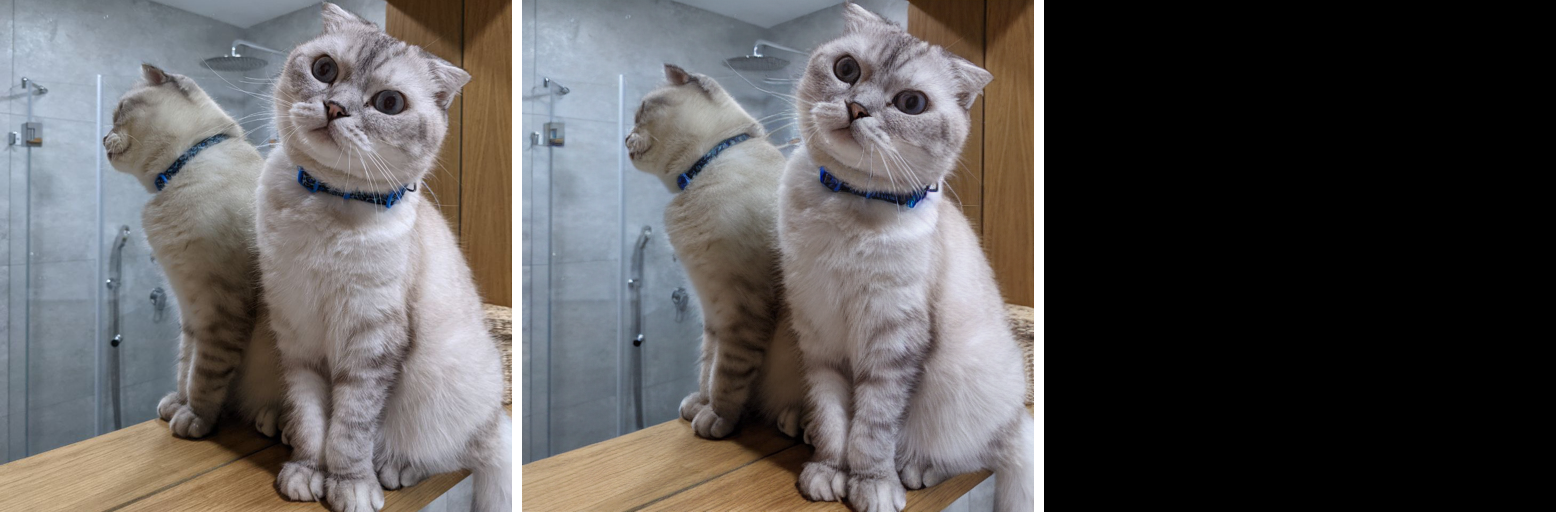

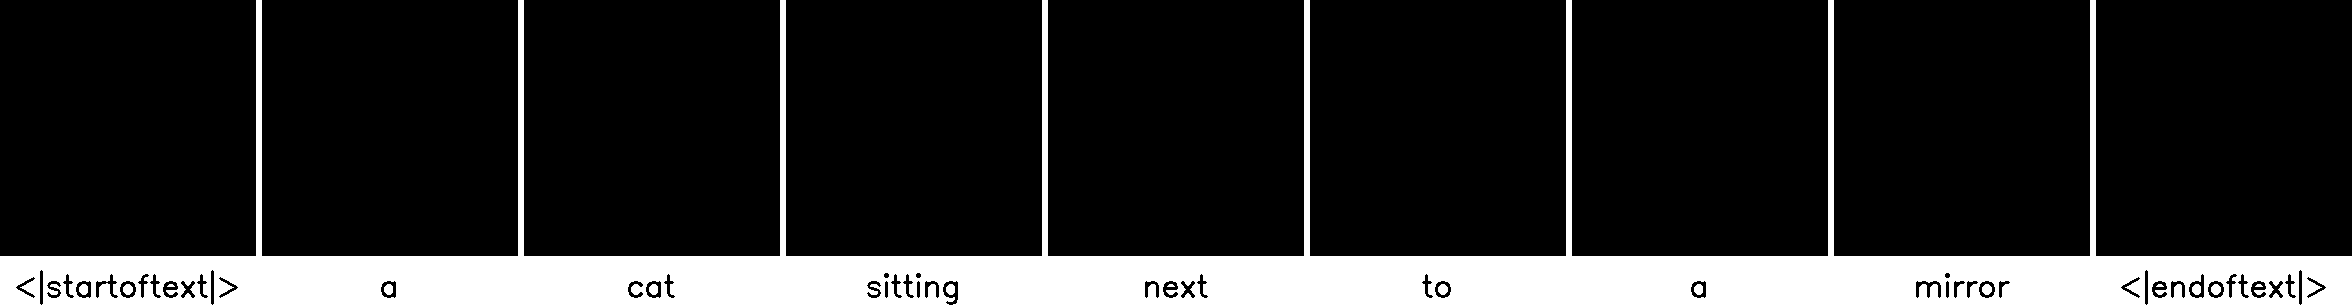

In [14]:
prompts = [prompt]
controller = AttentionStore()
image_inv, x_t = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, verbose=False)
print("showing from left to right: the ground truth image, the vq-autoencoder reconstruction, the null-text inverted image")
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(controller, 16, ["up", "down"])


#Tiger

In [15]:
prompts = ["a cat sitting next to a mirror",
           "a tiger sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .5
blend_word = ((('cat',), ("tiger",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("tiger",), "values": (2,)} # amplify attention to the word "tiger" by *2

controller = make_controller(prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)

print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

NameError: ignored

#Silver cat sculpture

In [ ]:
prompts = ["a cat sitting next to a mirror",
           "a silver cat sculpture sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .6
blend_word = ((('cat',), ("cat",))) # for local edit
eq_params = {"words": ("silver", 'sculpture', ), "values": (2,2,)}  # amplify attention to the words "silver" and "sculpture" by *2

controller = make_controller(prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)


#Watercolor

In [ ]:
prompts = ["a cat sitting next to a mirror",
           "watercolor painting of a cat sitting next to a mirror"
        ]

cross_replace_steps = {'default_': .8, }
self_replace_steps = .7
blend_word = None
eq_params = {"words": ("watercolor",  ), "values": (5, 2,)}  # amplify attention to the word "watercolor" by 5

controller = make_controller(prompts, False, cross_replace_steps, self_replace_steps, blend_word, eq_params)
images, _ = run_and_display(prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings)